<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-6143-ML/blob/main/6_k_nearest_neighbors_in_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K nearest neighbors in depth

*Fraida Fund*

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
from scipy import stats
sns.set_style("white")

# for 3d plots
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d
import ipywidgets as widgets

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import validation_curve, train_test_split

plot_colors = np.array(sns.color_palette().as_hex())

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Nearest neighbors classifier

Suppose we have a binary classification problem: we have a set of labeled inputs, where the labels are all either $0$ or $1$.

Our goal is to train a *classifier* to predict a $0$ or $1$ label for new, unseen test data.

One conceptually simple approach is to simply find the sample in the training data that is “most similar” to our test sample (a “neighbor” in the feature space), and then give the test sample the same label as the “most similar” training sample. This is the *nearest neighbors* classifier.

Consider the following plot, with training data shown in blue (negative class) and red (positive class). A test sample is shown in green.

In [ ]:
n_samples = 50

In [ ]:
# Generate training data
X = np.random.uniform(0, 1, size=(n_samples,2))
y = np.array(X[:,0]+X[:,1] >= 1).astype(int)

In [ ]:
# Generate a test point
x_test = np.random.uniform(0, 1, size=(1,2))

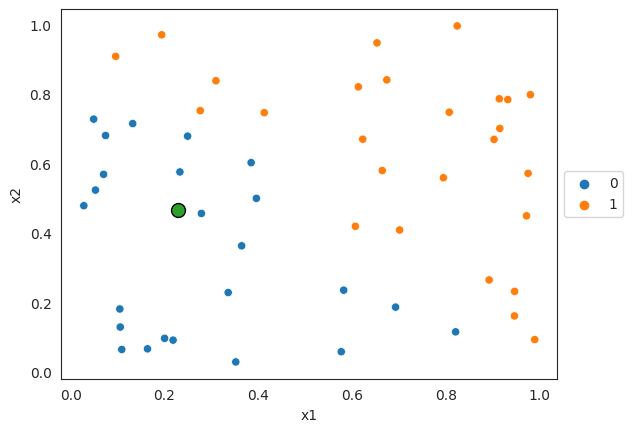

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

# Plot test point
plt.scatter(x=x_test[:,0], y=x_test[:,1], facecolor=plot_colors[2], edgecolor='black', s=100);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");

To find the nearest neighbor, we need a *distance metric*. I chose to use the L2 norm for this example.

The nearest neighbor to the test sample is circled, and its label is applied as the prediction for the test sample:

In [ ]:
k = 1
distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
nn = np.argsort(distances)[:k]
y_pred = y[nn]

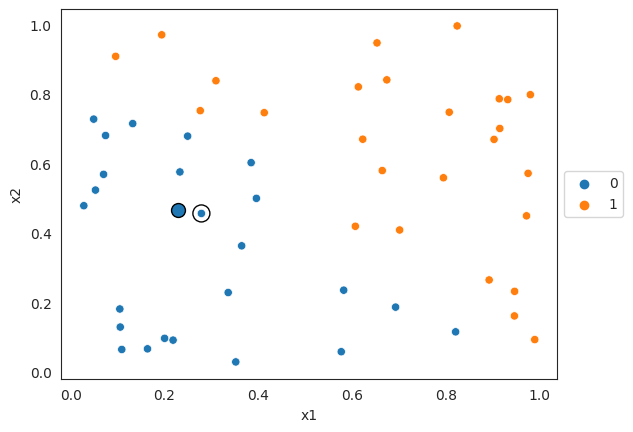

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

# Plot test point
plt.scatter(x=x_test[:,0], y=x_test[:,1], facecolor=plot_colors[y_pred], edgecolor='black', s=100);

# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', edgecolor='black', s=150);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");

The nearest neighbor classifier works by “memorizing” the training data. One interesting consequence of this is that it will have zero prediction error (or equivalently, 100% accuracy) on the training data, since each training sample's nearest neighbor is itself:

In [ ]:
k = 1
y_pred = np.zeros(n_samples)
for idx, x_sample in enumerate(X):
  distances = np.array([np.linalg.norm(x_sample - x_train, ord=2) for x_train in X])
  nn = np.argsort(distances)[:k]
  y_pred[idx] = y[nn]

In [ ]:
np.mean(y_pred==y)

1.0

## K nearest neighbors classifier

To make this approach less sensitive to noise, we might choose to look for multiple similar training samples to each new test sample, and classify the new test sample using the mode of the labels of the similar training samples.

This is $k$ nearest neighbors, where $k$ is the number of “neighbors” that we search for.

In the following plot, we show the same data as in the previous example. Now, however, the 3 closest neighbors to the test sample are circled, and the mode of their labels is used as the prediction for the new test sample.

In [ ]:
k = 3
distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
nn = np.argsort(distances)[:k]

y_pred = stats.mode(y[nn], keepdims=True).mode[0]

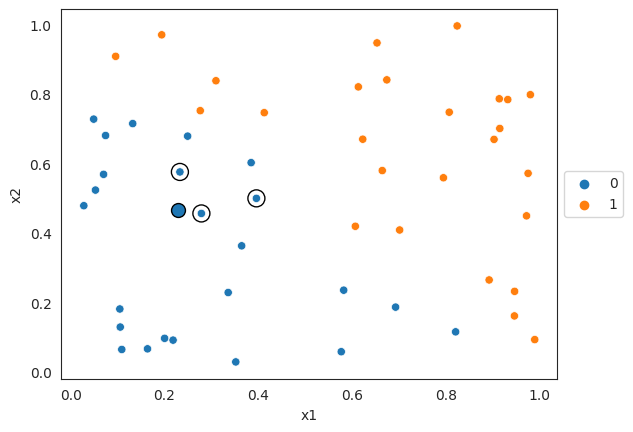

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

# Plot test point
plt.scatter(x=x_test[:,0], y=x_test[:,1], facecolor=plot_colors[y_pred], edgecolor='black', s=100);

# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', edgecolor='black', s=150);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");

The following image shows a set of test points plotted on top of the training data. The size of each test point indicate the *confidence* in the label, which we approximate by the proportion of $k$ neighbors sharing that label.

In [ ]:
n_test = 50
X_test = np.random.uniform(0, 1, size=(n_test,2))

In [ ]:
y_pred = np.zeros(n_test)
y_pred_prob = np.zeros(n_test)

for idx, x in enumerate(X_test):
  distances = np.array([np.linalg.norm(x - x_train, ord=2) for x_train in X])
  nn = np.argsort(distances)[:k]

  y_pred[idx] = stats.mode(y[nn], keepdims=True).mode[0]
  y_pred_prob[idx] = np.mean(y[nn]==y_pred[idx])

In [ ]:
y[nn], y_pred[idx]

(array([0, 0, 0]), 0.0)

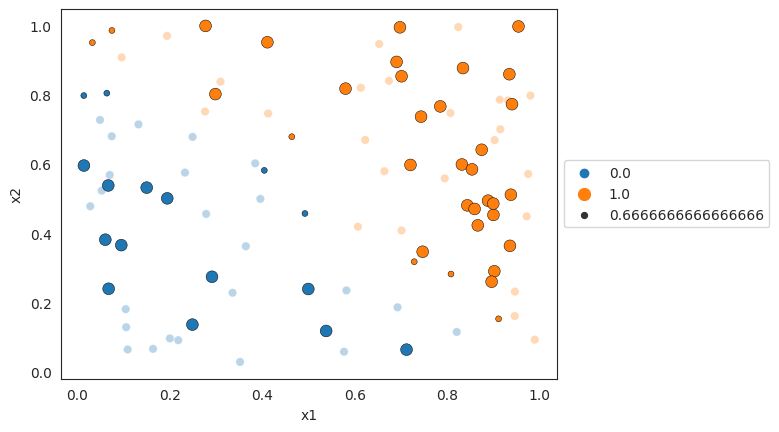

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.3, legend=False);

# Plot test points
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred, s=50,
                size=y_pred_prob, edgecolor='black', legend='full');

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

plt.xlabel("x1");
plt.ylabel("x2");

Also note that the training error for $k$ nearest neighbors is not *necessarily* zero (though it can be!), since a training sample may have a different label than its $k$ closest neighbors.

In [ ]:
y_pred = np.zeros(n_samples)
for idx, x_sample in enumerate(X):
  distances = np.array([np.linalg.norm(x_sample - x_train, ord=2) for x_train in X])
  nn = np.argsort(distances)[:k]
  y_pred[idx] = stats.mode(y[nn], keepdims=True).mode[0]

In [ ]:
np.mean(y_pred==y)

1.0

Instead of our hand-coded KNN classifier, let’s try the `sklearn` implementation.

Like other `sklearn` classification and regression models, we train it using a `fit` method, and make new predictions using a `predict` method.

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=k).fit(X, y)
y_pred  = clf_knn.predict(X_test)

because it makes it easier to get the decision regions/contours out of the classifier, and plot them on the same figure:

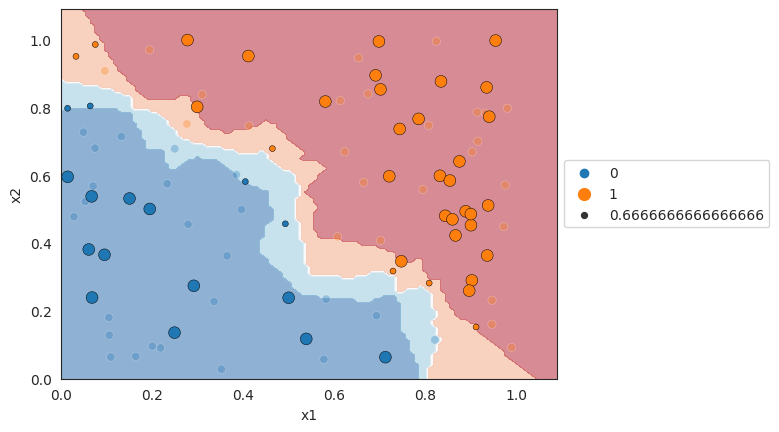

In [ ]:
# Plot the decision boundary
xx, yy = np.meshgrid(np.arange(0, 1.1, .01),
                      np.arange(0, 1.1, .01))
Z = clf_knn.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=5, cmap="RdBu_r", alpha=0.5);

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.3, legend=False);

# Plot test points
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_pred, s=50,
                size=y_pred_prob, edgecolor='black', legend='full');

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

plt.xlabel("x1");
plt.ylabel("x2");

Things to try:

-   What happens as we vary $k$?

## Feature scaling

One important limitation of $k$ nearest neighbors is that it does not “learn” anything about which features are most important for determining $y$. Every feature is weighted equally in finding the nearest neighbor.

The first implication of this is:

-   If all features are equally important, but they are not all on the same scale, they must be normalized - rescaled onto the interval $[0,1]$. Otherwise, the features with the largest magnitudes will dominate the total distance.

In [ ]:
n_samples = 100

In [ ]:
# Generate training data
X = np.random.uniform(0, 1, size=(n_samples,2))
y = np.array(X[:,0]+X[:,1] >= 1).astype(int)

In [ ]:
# Generate a test point
x_test = np.array([[0.5,0.5]])

In [ ]:
k = 5
distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
nn = np.argsort(distances)[:k]

y_pred = stats.mode(y[nn], keepdims=True).mode[0]

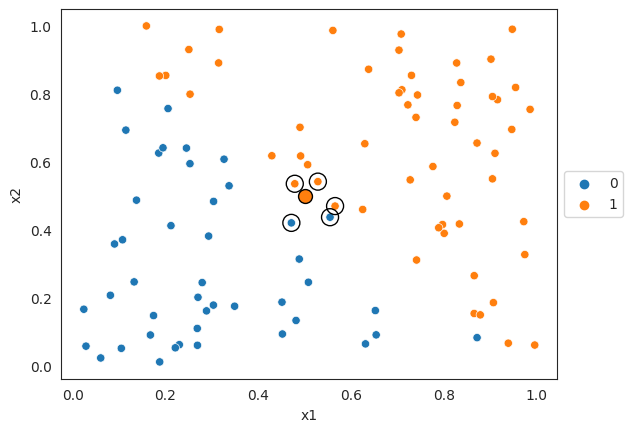

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

# Plot test point
plt.scatter(x=x_test[:,0], y=x_test[:,1], facecolor=plot_colors[y_pred], edgecolor='black', s=100);

# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', edgecolor='black', s=150);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");

In [ ]:
X[:,0] = 100*X[:,0]
x_test[:,0] = 100*x_test[:,0]

In [ ]:
distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
nn = np.argsort(distances)[:k]

y_pred = stats.mode(y[nn], keepdims=True).mode[0]

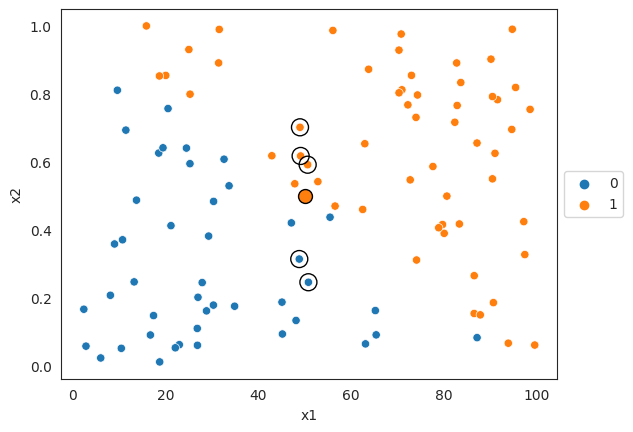

In [ ]:
# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

# Plot test point
plt.scatter(x=x_test[:,0], y=x_test[:,1], facecolor=plot_colors[y_pred], edgecolor='black', s=100);

# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', edgecolor='black', s=150);

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");

The second implication is:

-   Even if some features are more important than others, they will all be considered equally important in the distance calculation. If uninformative features are included, they may dominate the distance calculation.

Contrast this with our logistic regression classifier. In the logistic regression, the training process involves learning coefficients. The coefficients weight each feature's effect on the overall output.

Consider the following images from CIFAR10, a dataset of low-resolution images in ten classes:

In [ ]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 2s 0us/step


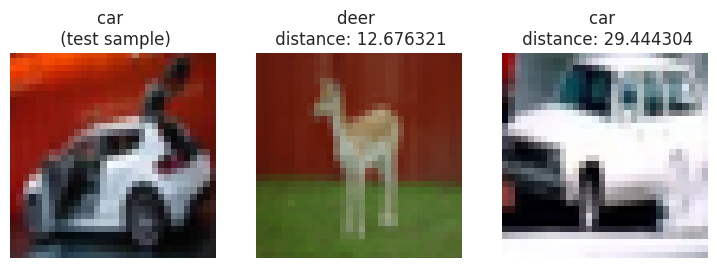

In [ ]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 3,1)

plt.imshow(X_test[6].astype('uint8'));
plt.title("%s \n (test sample)" % classes[y_test[6][0]]);
plt.axis('off');

plt.subplot(1,3,2)

plt.imshow(X_train[38805].astype('uint8'));
dist = np.linalg.norm(X_train[38805].ravel()*1.0/255-X_test[6].ravel()*1.0/255, ord=2)
plt.title("%s \n distance: %f" % (classes[y_train[38805][0]], dist));
plt.axis('off');

plt.subplot(1,3,3)

plt.imshow(X_train[32488].astype('uint8'));
dist = np.linalg.norm(X_train[32488].ravel()*1.0/255-X_test[6].ravel()*1.0/255, ord=2)
plt.title("%s \n distance: %f" % (classes[y_train[32488][0]], dist));
plt.axis('off');

The images above show a test sample, and two training samples with their distances to the test sample.

The background pixels in the test sample “count” just as much as the foreground pixels, so that the image of the deer is considered a very close neighbor, while the image of the car is not.

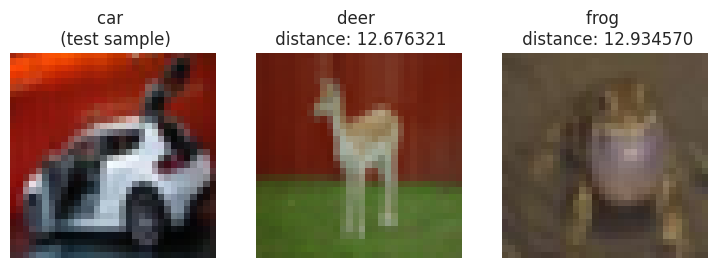

In [ ]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 3,1)

plt.imshow(X_test[6].astype('uint8'));
plt.title("%s \n (test sample)" % classes[y_test[6][0]]);
plt.axis('off');

plt.subplot(1,3,2)

plt.imshow(X_train[38805].astype('uint8'));
dist = np.linalg.norm(X_train[38805].ravel()*1.0/255-X_test[6].ravel()*1.0/255, ord=2)
plt.title("%s \n distance: %f" % (classes[y_train[38805][0]], dist));
plt.axis('off');

plt.subplot(1,3,3)

plt.imshow(X_train[20278].astype('uint8'));
dist = np.linalg.norm(X_train[20278].ravel()*1.0/255-X_test[6].ravel()*1.0/255, ord=2)
plt.title("%s \n distance: %f" % (classes[y_train[20278][0]], dist));
plt.axis('off');

(We also see here that pixel-wise L2 distance is not a good measure of visual similarity - the frog on the right is almost as similar to the car as the deer in the middle!)

## Complex decision boundaries

In the classification example above, the two classes were separated by a linear *decision boundary*.

One of the major benefits of $k$ nearest neighbors is its ability to capture complex decision boundaries. Consider the following example, where the two classes are separated by a polynomial boundary.

In [ ]:
n_samples = 1000
sigma = 0.1
k = 3
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [ ]:
def generate_polynomial_classifier_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], size=(n, 2))
  ysep = np.polynomial.polynomial.polyval(x[:,0],coefs)
  y = (x[:,1]>ysep).astype(int)
  x[:,0] = x[:,0] + sigma * np.random.randn(n)
  x[:,1] = x[:,1] + sigma * np.random.randn(n)
  return x, y

In [ ]:
X, y = generate_polynomial_classifier_data(n=n_samples, xrange=xrange, coefs=coefs, sigma=sigma)

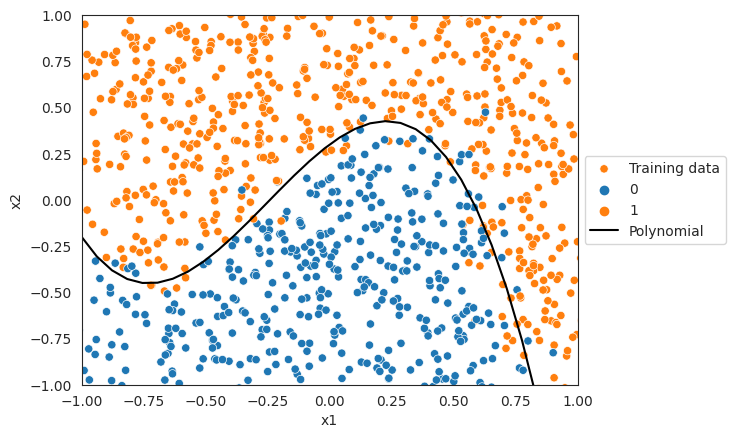

In [ ]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, label="Training data");

# Plot true function
xtrue = np.linspace(-1, 2)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', label='Polynomial')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);
plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

We will use the `sklearn` implementation of a `KNeighborsClassifier` to learn this training data and use it for new predictions.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k).fit(X, y)

Then, we can plot out the predictions of the model over the input space:

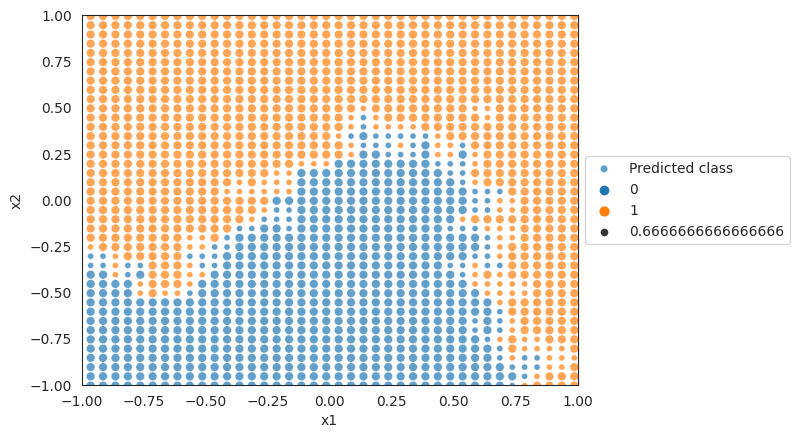

In [ ]:
# Plot the decisions
xx, yy = np.meshgrid(np.arange(1.1*X[:,0].min(), 1.1*X[:,0].max(), .05),
                      np.arange(1.1*X[:,1].min(), 1.1*X[:,1].max(), .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=Z.ravel(),
                size=Z_prob.max(axis=1),
                sizes=(20,40),
                legend='full', alpha=0.7, label="Predicted class");

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Or equivalently, as a contour plot:

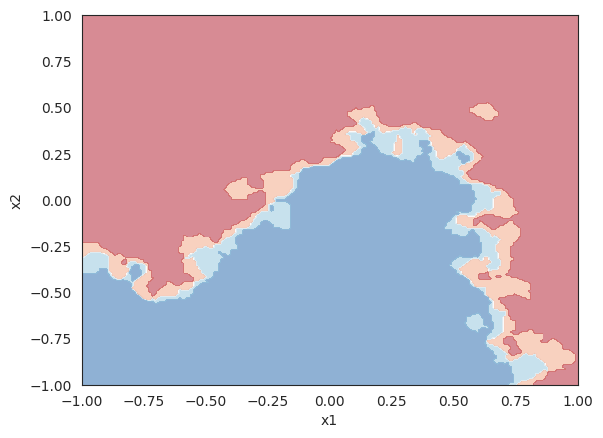

In [ ]:
# Plot the decision boundary
xx, yy = np.meshgrid(np.arange(1.1*X[:,0].min(), 1.1*X[:,0].max(), .01),
                      np.arange(1.1*X[:,1].min(), 1.1*X[:,1].max(), .01))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=5, cmap="RdBu_r", alpha=0.5);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

Things to try:

-   What happens as we vary $k$?
-   What happens as we vary $\sigma$?

## K nearest neighbors regression

K nearest neighbors can also be used for regression, with just a small change: instead of using the mode of the nearest neighbors to predict the label of a new sample, we use the mean.

Consider the following training data:

In [ ]:
n_samples = 100
X = np.random.uniform(-6, 6, size=(n_samples,2))
y = np.sin(np.sqrt(X[:,0] ** 2 + X[:,1] ** 2))

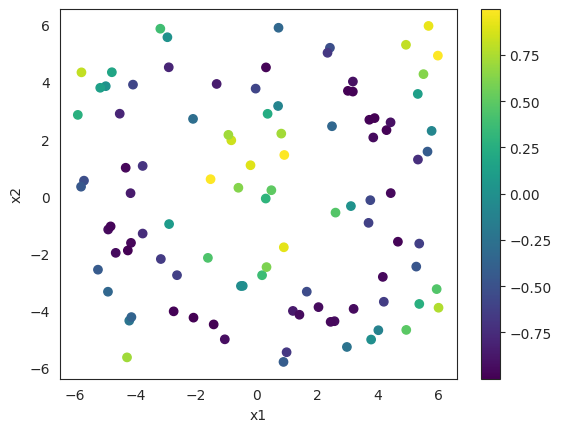

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis');
cbar = plt.colorbar();

plt.xlabel("x1");
plt.ylabel("x2");

We can add a test sample, then use $k$ nearest neighbors to predict its value:

In [ ]:
x_test = np.random.uniform(-6, 6, size=(1,2))

In [ ]:
k = 2
distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
nn = np.argsort(distances)[:k]

y_pred = np.mean(y[nn])

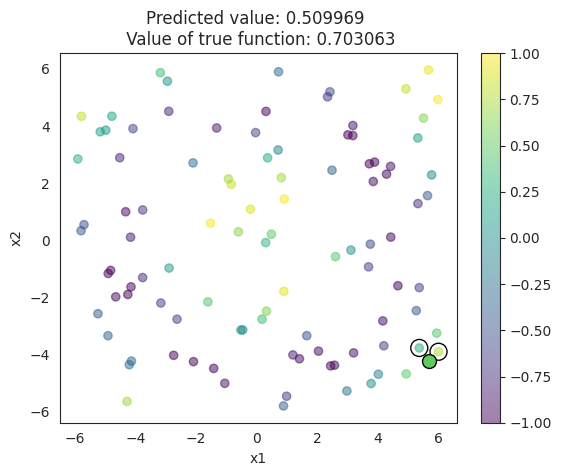

In [ ]:
# Plot training data
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=0.5, vmin=-1, vmax=1);
cbar = plt.colorbar();

# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', edgecolor='black', s=150);

# Plot test point with prediction
plt.scatter(x_test[:,0], x_test[:,1], c=y_pred, s=100, edgecolor='black', cmap='viridis', vmin=-1, vmax=1);

# Plot formatting stuff
plt.xlabel("x1");
plt.ylabel("x2");

plt.title("Predicted value: %f \n Value of true function: %f" %
          (y_pred,
          np.sin(np.sqrt(x_test[:,0] ** 2 + x_test[:,1] ** 2))));

With the `sklearn` implementation:

In [ ]:
reg_knn = KNeighborsRegressor(n_neighbors = k).fit(X, y)

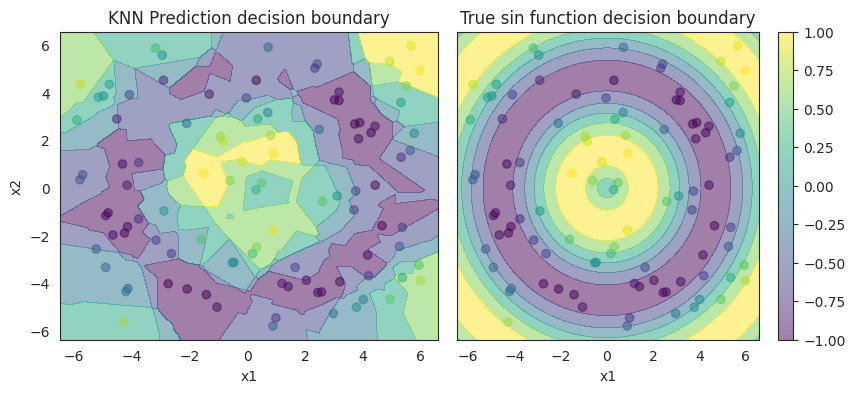

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1, )

# Plot the decision boundary
xx, yy = np.meshgrid(np.arange(1.1*X[:,0].min(), 1.1*X[:,0].max(), .01),
                      np.arange(1.1*X[:,1].min(), 1.1*X[:,1].max(), .01))
Z = reg_knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=5, cmap='viridis', vmin=-1, vmax=1, alpha=0.5);

# Plot training data
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap='viridis', vmin=-1, vmax=1, alpha=0.5);
plt.title("KNN Prediction decision boundary")

plt.xlabel("x1");
plt.ylabel("x2");

plt.subplot(1,2,2)

# Plot the decision boundary
Z = np.sin(np.sqrt(xx.ravel() ** 2 +  yy.ravel() ** 2))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=5, cmap='viridis', vmin=-1, vmax=1, alpha=0.5);

# Plot training data
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap='viridis', vmin=-1, vmax=1, alpha=0.5);
plt.title("True sin function decision boundary")

plt.colorbar();
plt.subplots_adjust(wspace=0.05)
plt.xlabel("x1");
plt.yticks(ticks=[], labels=[]);

Things to try:

-   What happens as we vary $k$?
-   What if $k=N_\text{train}$?

## Bias and variance

Recall that:

-   The bias of a model for a given test point is the difference between the value of the *true* function at that point and the *mean* prediction of the model, if it was trained many times on independent training sets.
-   The variance of a model is the variance in the prediction of the model for that point.

For the data above, which classifier do you think will have greater bias, and which classifier do you think will have greater variance?

-   **Model A**: K nearest neighbors with $k=1$
-   **Model B**: K nearest neighbors with $k=15$

As in previous lessons, we can verify our intuition by simulation:

In [ ]:
n_repeat = 200
n_plot = 20
n_test = 500
n_train = 200
sigma= 0.1
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [ ]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [ ]:
# generate test data once
x_test, y_test = generate_polynomial_classifier_data(n=n_test, xrange=xrange, coefs=coefs, sigma=sigma)

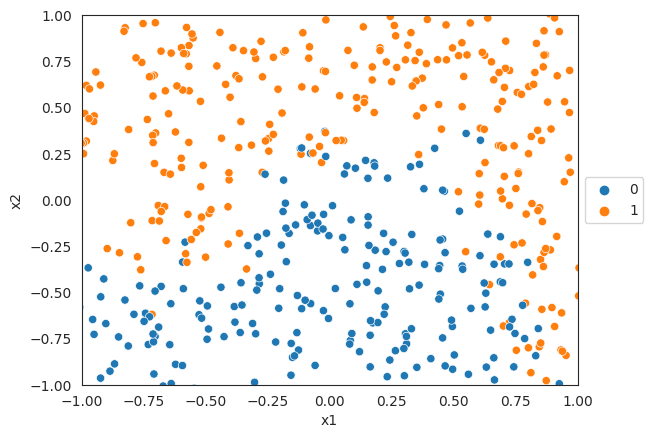

In [ ]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

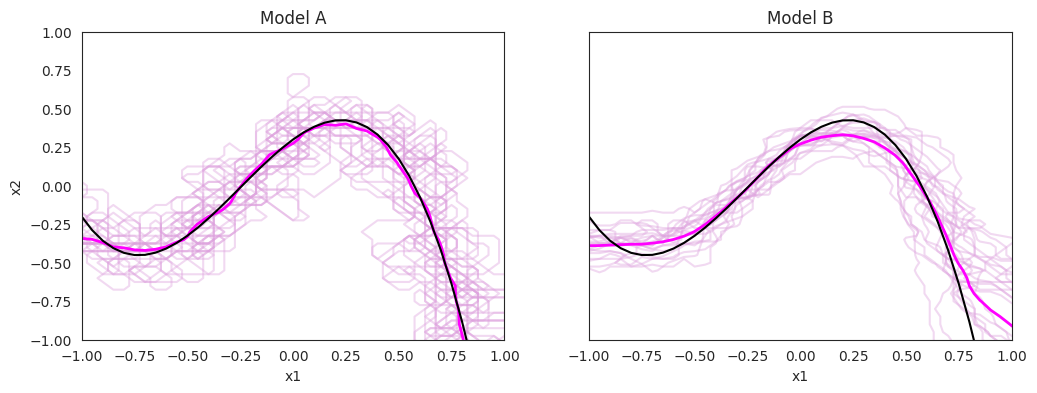

In [ ]:
Z_sim = np.zeros((3600, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in range(n_repeat):

  # train both models on newly generated training data
  X, y = generate_polynomial_classifier_data(n=n_train, xrange=xrange, coefs=coefs, sigma=sigma)

  clf_a = KNeighborsClassifier(n_neighbors=1).fit(X, y)
  clf_b = KNeighborsClassifier(n_neighbors=15).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)

  xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .05),
                      np.arange(-1.5, 1.5, .05))
  Z_a = clf_a.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z_sim[:, i, 0] = Z_a
  Z_b = clf_b.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z_sim[:, i, 1] = Z_b

  if i < n_plot:

    ax_a.contour(xx, yy, Z_a.reshape(xx.shape), levels=[0.5], alpha=0.4, colors='plum');
    plt.xlim((xrange[0], xrange[1]));
    plt.ylim((xrange[0], xrange[1]));

    ax_b.contour(xx, yy, Z_b.reshape(xx.shape), levels=[0.5], alpha=0.4, colors='plum');
    plt.xlim((xrange[0], xrange[1]));
    plt.ylim((xrange[0], xrange[1]));


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);


# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_a);
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_b);

ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

In [ ]:
# computation of bias and variance *of the boundary*, not of the estimated class labels
var_a = np.var(Z_sim[:,:,0], axis=1).mean()
mean_pred_a = cs_a.collections[0].get_paths()[0].vertices
x_mean_pred_a = mean_pred_a[:,0]
y_mean_pred_a = mean_pred_a[:,1]
bias_a = np.mean((y_mean_pred_a - np.polynomial.polynomial.polyval(x_mean_pred_a,coefs))**2)


var_b = np.var(Z_sim[:,:,1], axis=1).mean()
mean_pred_b = cs_b.collections[0].get_paths()[0].vertices
x_mean_pred_b = mean_pred_b[:,0]
y_mean_pred_b = mean_pred_b[:,1]
bias_b = np.mean((y_mean_pred_b - np.polynomial.polynomial.polyval(x_mean_pred_b,coefs))**2)


print("Model A: \n Bias^2 on boundary: %f \n Variance on boundary: %f " % (bias_a, var_a));
print("Model B: \n Bias^2 on boundary: %f \n Variance on boundary: %f " % (bias_b, var_b));

Model A: 
 Bias^2 on boundary: 0.183794 
 Variance on boundary: 0.040694 
Model B: 
 Bias^2 on boundary: 2.808851 
 Variance on boundary: 0.005518 


Things to try:

-   What happens as we vary $k$?
-   What happens as we vary $\sigma$?
-   What happens as we vary $N$?

Refer to class notes for derivation, but:

-   Variance of $k$ nearest neighbors increases with $\sigma$, decreases with $k$
-   Bias of $k$ nearest neighbors tends to increase with $k$, if the true function $t(x)$ is smooth.

(The few closest neighbors to a test point are likely to have similar values, and their average will be close to the value of the true function in that “neighborhood”. As $k$ increases, and we begin to include neighbors that are far away, their average may be very different from the value of the true function at that test point.)

## Choosing $k$ with cross validation

As with other hyperparameters that control the bias-variance tradeoff, we can choose the optimal $k$ for a particular problem with K-fold cross validation.

In this section, we demonstrate the use of the `sklearn` `validation_curve` function for this purpose.

First, we generate training data:

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(noise=0.2, factor=0.5, random_state=0, n_samples=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 75)

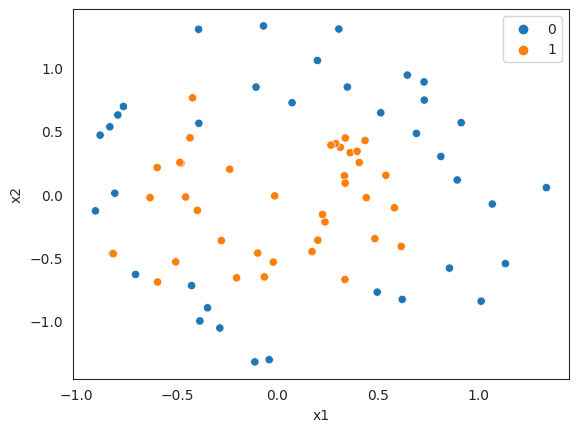

In [ ]:
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=y_train);
plt.xlabel("x1");
plt.ylabel("x2");

Then, we compute and plot the K-fold CV training scores and validation scores for a range of values of $k$ (number of neighbors).

In [ ]:
max_k = 10
n_fold = 10

In [ ]:
train_scores, valid_scores = validation_curve(
                            KNeighborsClassifier(),
                            X_train, y_train,
                            param_name="n_neighbors",
                            param_range=np.arange(1, max_k, 2),
                            cv=n_fold)

In [ ]:
acc_val_mean = valid_scores.mean(axis=1)
acc_val_se   = valid_scores.std(axis=1)/np.sqrt(n_fold-1)

acc_tr_mean = train_scores.mean(axis=1)
acc_tr_se   = train_scores.std(axis=1)/np.sqrt(n_fold-1)

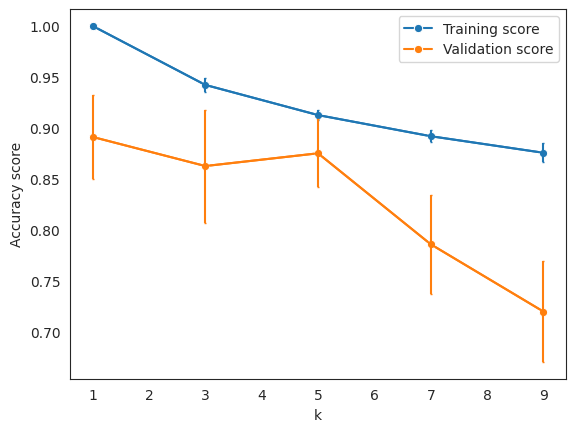

In [ ]:
sns.lineplot(x=np.arange(1,max_k, 2), y=acc_tr_mean, marker='o', label="Training score", color=plot_colors[0]);
sns.lineplot(x=np.arange(1,max_k, 2), y=acc_val_mean, marker='o', label="Validation score", color=plot_colors[1]);

plt.errorbar(x=np.arange(1,max_k, 2), y=acc_tr_mean, yerr=acc_tr_se, label="Training score", capsize=1);
plt.errorbar(x=np.arange(1,max_k, 2), y=acc_val_mean, yerr=acc_val_se, label="Validation score", capsize=1);

plt.xlabel("k");
plt.ylabel("Accuracy score");

Then, we can select the best model according to the 1-SE rule.

Note that the mode with the *largest* number of neighbors is the “simplest” model, in the sense that it has the smoothest decision boundary.

In [ ]:
# selecting best model for KNN
# we are looking for the *largest* number of neighbors with score no
# more than one SE *less than* the *maximum* score
nn_list = np.arange(1, max_k, 2)

# index of *maximum* score value
idx_best = np.argmax(acc_val_mean)
# target is no more than one SE *less than* that
target = acc_val_mean[idx_best] - acc_val_se[idx_best]

# get largest number of neighbors (simplest model)
# where mean score is still greater than target
idx_1se = max(np.where(acc_val_mean >= target)[0])
nn_1se = nn_list[idx_1se]
print("Best model has number of neighbors: %d" % nn_1se)

Best model has number of neighbors: 5


In [ ]:
idx_best, acc_val_mean[idx_best], target

(0, 0.8910714285714285, 0.8498794041028667)

## The “curse of dimensionality”

Classifiers that rely on pairwise distance between points, like the $k$ neighbors methods, are heavily impacted by a problem know as the “curse of dimensionality”. In this section, we will illustrate the problem.

In [ ]:
n_samples = 30
k = 3

We will look at a problem with data uniformly distributed in each dimension of the feature space, and two classes separated by a linear boundary.

We will generate a test point, and show the $k$ nearest neighbors to the test point. We will also show the length (or area, or volume) that we had to search to find those $k$ test points.

Pay special attention to how that length (or area, or volume) changes as we increase the dimensionality of the feature space.

In [ ]:
X = np.random.uniform(0, 1, size=(n_samples,3))
y = np.array(X.sum(axis=1) >= 1.5).astype(int)

x_test = 0.5*np.ones(3)

First, the 1D problem:

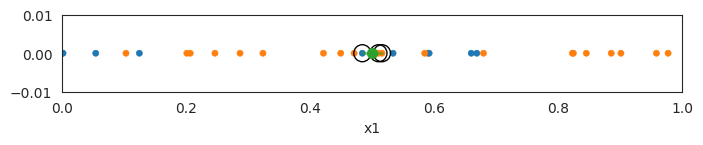

In [ ]:
# Get nearest neighbors
distances = np.array([np.linalg.norm([x_test[0]] - x_train, ord=2) for x_train in X[:, 0]])
nn = np.argsort(distances)[:k]
mdist = np.max(distances[nn])

# Figure formatting stuff
plt.figure(figsize=(8,1))
plt.xlim(0,1);
plt.ylim(-0.01, 0.01);
plt.xlabel("x1")
# Plot training data
sns.scatterplot(x=X[:,0], y=0, hue=y, s=20, edgecolor=None, legend=False);
# Plot region that encloses nearest neighbors
plt.plot([x_test-mdist, x_test+mdist], [0,0], color=plot_colors[2], lw=2, alpha=0.2);
# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=0, facecolors='none', edgecolor='black', s=150);
# Plot test point
plt.scatter(x=x_test[0], y=0, facecolor=plot_colors[2], s=50);

Now, the 2D equivalent:

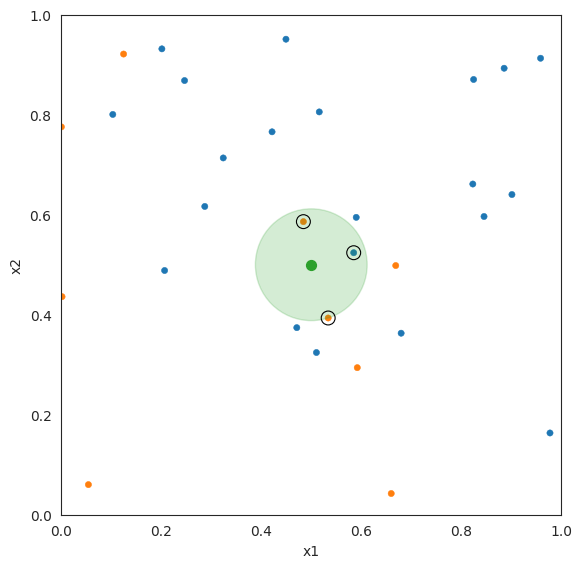

In [ ]:
# Get nearest neighbors
distances = np.array([np.linalg.norm(x_test[0:2] - x_train, ord=2) for x_train in X[:, 0:2]])
nn = np.argsort(distances)[:k]
mdist = np.max(distances[nn])

# Figure formatting stuff
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1])
plt.xlim(0,1);
plt.ylim(0,1);
plt.xlabel("x1")
plt.ylabel("x2")

# Plot training data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=plot_colors[y], s=20, edgecolor=None, legend=False, ax=ax);
# Plot region that encloses nearest neighbors
circle = plt.Circle(x_test,mdist,
                          fill=True, color=plot_colors[2], alpha=0.2, zorder=1)
ax.add_patch(circle)
# Plot nearest neighbors
sns.scatterplot(x=X[nn,0], y=X[nn,1], facecolors='none', s=100, edgecolor='black', legend=False, ax=ax);
# Plot test point
plt.scatter(x=x_test[0], y=x_test[1], facecolor=plot_colors[2], s=50);

Finally, the 3D equivalent:

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
def plot_3D(elev=20, azim=-20, X=X, y=y, x_test=x_test):
    # Figure formatting stuff
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_zlim(0, 1)


    # Get nearest neighbors
    distances = np.array([np.linalg.norm(x_test - x_train, ord=2) for x_train in X])
    nn = np.argsort(distances)[:k]
    mdist = np.max(distances[nn])

    # Plot training data
    ax.scatter3D(X[:,0], X[:,1], X[:,2], s=50, c=plot_colors[y])

    # Plot region that encloses nearest neighbors
    u, v = np.mgrid[0:2*np.pi:16*1j, 0:np.pi:8*1j]
    sphere_x = x_test[0] + mdist * np.cos(u) * np.sin(v)
    sphere_y = x_test[1] + mdist * np.sin(u) * np.sin(v)
    sphere_z = x_test[2] + mdist * np.cos(v)
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, alpha=0.2, color=plot_colors[2])

    # Plot nearest neighbors
    ax.scatter3D(X[nn,0], X[nn,1], X[nn,2], s=150, c=plot_colors[y[nn]], edgecolor='black')

    # Plot test point
    ax.scatter3D(x_test[0], x_test[1], x_test[2], s=200, color=plot_colors[2])

    plt.show();

interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         X=fixed(X), y=fixed(y), x_test=fixed(x_test));

interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…

We can see that as the dimensionality of the problem grows, the higher-dimensional space is less densely occupied by the training data, and we need to search a large volume of space to find neighbors of the test point. **The pair-wise distance between points grows** as we add additional dimensions.

And in that case, the neighbors may be so far away that they don’t actually have much in common with the test point.

Things to try:

-   What happens as we vary $k$?
-   What happens as we vary $N$?

(Note that a separating hyperplane is not affected the same way - see [these notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html) for more details.)

In general, the length of the smallest hyper-cube that contains all $k$-nearest neighbors of a test point is:

$$\left(\frac{k}{N}\right)^{\frac{1}{d}}$$

for $N$ samples with dimensionality $d$.

From the expression above, we can see that as number of dimensions increases *linearly*, the number of training samples must increase *exponentially* to counter the “curse”

Alternatively, we can reduce $d$ - either by feature selection, or by transforming the data into a lower-dimensional space.

(In the unsupervised learning unit of this course, we will learn some methods to transform the high-dimensional data into a lower-dimensional space.)